# Data preprocessing

In [1]:
import csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score

data = []
scaler = MinMaxScaler()

def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        aux = dataset[i:(i+look_back)]
        dataX.append(aux)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def get_average(row, col, data):
    sum = 0
    for i in range(row-12, row, 1):
        sum+=data[i][col]
    return sum/12


def remove_missing_values(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == 0:
                data[i][j] = get_average(i, j, data)


with open('./datasets/traffic-prediction-dataset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        row_to_append = [float(x) for x in row[0:4]]
        data.append(row_to_append)

remove_missing_values(data)

/home/paolo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Plot Data

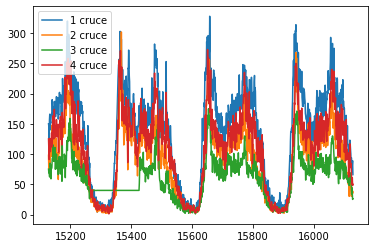

In [30]:
import matplotlib.pyplot as plt
import numpy

x = [i for i in range(len(data))]
y = numpy.transpose(data)

fig, ax = plt.subplots()

registers = 1000

for i in range(len(y)):
    ax.plot(x[-registers:], y[i][-registers:], label= str(i+1) + " cruce")

ax.legend(loc = 'upper left')
plt.savefig("comportamiento_datos2.jpg")
plt.show()

In [13]:
scaler.fit(data)
normalized_data = scaler.transform(data)
normalized_data

array([[0.296875  , 0.15754561, 0.13364055, 0.19743178],
       [0.27414773, 0.13432836, 0.14285714, 0.17495987],
       [0.21448864, 0.15422886, 0.19815668, 0.18459069],
       ...,
       [0.234375  , 0.11111111, 0.15207373, 0.19422151],
       [0.25142045, 0.12769486, 0.11059908, 0.15248796],
       [0.18607955, 0.11774461, 0.11520737, 0.15890851]])

# Train and Test Sets

In [14]:
train_size = int(len(normalized_data) * 0.75)
test_size = len(normalized_data) - train_size

train, test = normalized_data[0:train_size,:], normalized_data[train_size:len(normalized_data),:]
x_train, y_train = create_dataset(train)
x_test, y_test = create_dataset(test)
y_real = scaler.inverse_transform(y_test)

# Recurrent Neural Networks

In [15]:
train_rnn_size = int(len(x_train)*0.95)

x_train_rnn, y_train_rnn = x_train[0:train_rnn_size,:], y_train[0:train_rnn_size,:]
x_val_rnn, y_val_rnn = x_train[train_rnn_size:len(x_train),:], y_train[train_rnn_size:len(y_train),:]

## Training LSTM-NN

In [23]:
from keras import Input
from keras.models import Sequential 
from keras.layers import Dense, Dropout, InputLayer
from keras.layers import LSTM
from keras.callbacks import History 

history_lstm = History()


lstm_model = Sequential()
lstm_model.add(InputLayer(input_shape=(12, 4)))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')
lstm_model.summary()

lstm_model.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=128, validation_data=(x_val_rnn, y_val_rnn), callbacks=[history_lstm])

2022-11-08 21:16:29.225064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 21:16:29.654381: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-08 21:16:29.770137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 21:16:29.770150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 50,948
Trainable params: 50,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
90/90 [==============================] - 5s 25ms/step - loss: 0.0113 - val_loss: 0.0044
Epoch 2/50
90/90 [==============================] - 2s 18ms/step - loss: 0.0055 - val

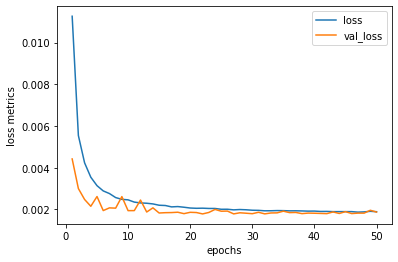

In [24]:
import matplotlib.pyplot as plt

epochs = [i+1 for i in range(50)]
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

plt.plot(epochs, loss_lstm)
plt.plot(epochs, val_loss_lstm)
plt.xlabel("epochs")
plt.ylabel("loss metrics")
plt.legend(['loss', 'val_loss'])
plt.savefig("loss_lstm.jpg")

## Testing LSTM-NN

In [25]:
y_pred_lstm = lstm_model.predict(x_test)

y_real_pred_lstm = scaler.inverse_transform(y_pred_lstm)
 
print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_lstm))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_lstm))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_lstm, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_lstm))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_lstm))

126/126 [==============================] - 3s 12ms/step
Mean Absolute error: 10.863333462227251
Mean Absolute Percentage error: 0.23787023934242313
Mean Squared error: 15.322384533716498
R-Squared score: 0.9307414225472641
Explained Variance score: 0.9338203868287869


## Training GRU-NN

In [26]:
from keras.layers import GRU

history_gru = History()

gru_model = Sequential()
gru_model.add(InputLayer(input_shape=(12, 4)))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(4))
gru_model.compile(loss='mean_squared_error', optimizer='rmsprop')
gru_model.summary()

gru_model.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=128, validation_data=(x_val_rnn, y_val_rnn), callbacks=[history_gru])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 64)            13440     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 38,660
Trainable params: 38,660
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
90/90 [==============================] - 16s 69ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 2/50
90/90 [==============================] - 4s 40ms/step - loss: 0.0039 - 

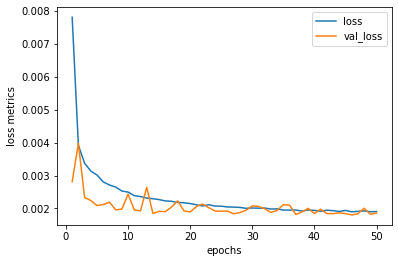

In [27]:
epochs = [i+1 for i in range(50)]
loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

plt.plot(epochs, loss_gru)
plt.plot(epochs, val_loss_gru)
plt.xlabel("epochs")
plt.ylabel("loss metrics")
plt.legend(['loss', 'val_loss'])
plt.savefig("loss_gru.jpg")

## Testing GRU-NN

In [28]:
y_pred_gru = gru_model.predict(x_test)

y_real_pred_gru = scaler.inverse_transform(y_pred_gru)
 
print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_gru))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_gru))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_gru, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_gru))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_gru))

126/126 [==============================] - 3s 11ms/step
Mean Absolute error: 10.845757902387128
Mean Absolute Percentage error: 0.21443019184120043
Mean Squared error: 15.27434476074778
R-Squared score: 0.9308224454345484
Explained Variance score: 0.9322776179233965


# Machine Learning Models

In [16]:
def array3dto2d(array):
    return array.reshape(array.shape[0], (array.shape[1]*array.shape[2]))

x_train2d = array3dto2d(x_train)
x_test2d = array3dto2d(x_test)

## Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression().fit(x_train2d, y_train)
linear_regression_prediction = linear_regression_model.predict(x_test2d)

y_real_pred_lr = scaler.inverse_transform(linear_regression_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_lr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_lr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_lr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_lr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_lr))

Mean Absolute error: 10.71465980579633
Mean Absolute Percentage error: 0.22798158251398565
Mean Squared error: 15.259452852929437
R-Squared score: 0.9314946611234465
Explained Variance score: 0.9315809657755724


## Gradient Boosting Regressor

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gradient_boosting_regressor_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(x_train2d, y_train)
gradient_boosting_regressor_prediction = gradient_boosting_regressor_model.predict(x_test2d)

y_real_pred_gbr = scaler.inverse_transform(gradient_boosting_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_gbr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_gbr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_gbr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_gbr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_gbr))

Mean Absolute error: 10.870180659581173
Mean Absolute Percentage error: 0.22501882793993233
Mean Squared error: 15.520450188091582
R-Squared score: 0.9302567153664071
Explained Variance score: 0.9303702365279769


## MultiLayer Perceptron Regressor

In [20]:
from sklearn.neural_network import MLPRegressor

mlp_regressor_model = MLPRegressor(random_state=0).fit(x_train2d, y_train)
mlp_regressor_prediction = mlp_regressor_model.predict(x_test2d)

y_real_pred_mlpr = scaler.inverse_transform(mlp_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_mlpr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_mlpr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_mlpr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_mlpr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_mlpr))

Mean Absolute error: 11.183727757747286
Mean Absolute Percentage error: 0.23284236394794786
Mean Squared error: 15.79474246889842
R-Squared score: 0.9254334684507739
Explained Variance score: 0.9260582219240916


## Stochastic Gradient Descendent Regressor

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_regressor_model = MultiOutputRegressor(SGDRegressor(random_state=0)).fit(x_train2d, y_train)
sgd_regressor_prediction = sgd_regressor_model.predict(x_test2d)

y_real_pred_sgdr = scaler.inverse_transform(sgd_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_sgdr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_sgdr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_sgdr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_sgdr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_sgdr))

Mean Absolute error: 11.74829963099881
Mean Absolute Percentage error: 0.26079931185034494
Mean Squared error: 16.8074534522024
R-Squared score: 0.9152501009859436
Explained Variance score: 0.9161564973474278


## Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor(random_state=0).fit(x_train2d, y_train)
random_forest_regressor_prediction = random_forest_regressor_model.predict(x_test2d)

y_real_pred_rfr = scaler.inverse_transform(random_forest_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_rfr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_rfr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_rfr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_rfr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_rfr))

Mean Absolute error: 12.179725119576856
Mean Absolute Percentage error: 0.2393119828082888
Mean Squared error: 18.565119295436972
R-Squared score: 0.8961775603045601
Explained Variance score: 0.8975877988094121
